In [1]:
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
from IPython import display
!pip install -U tensorboard
import numpy as np
!pip install -q imageio
from tensorflow.keras import layers
import glob
import imageio
import PIL
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model



Requirement already up-to-date: tensorboard in d:\faculty\development\venv\lib\site-packages (2.2.2)


Using TensorFlow backend.


In [2]:
!python --version

Python 3.8.3


In [2]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)


PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')


In [3]:
_URL_MAPS = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz'

path_to_zip_maps = tf.keras.utils.get_file('maps.tar.gz',
                                      origin=_URL_MAPS,
                                      extract=True)


PATH_MAPS = os.path.join(os.path.dirname(path_to_zip_maps), 'maps/')

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT= 256

In [5]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]
  w = w//2
  real_image = image[:,:w,:]
  input_image = image[:,w:,:]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

  

In [6]:
def load_png(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image)
  image = tf.cast(image,tf.float32)
  return image

In [7]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  return input_image, real_image

In [8]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [9]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [10]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

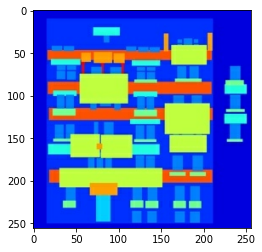

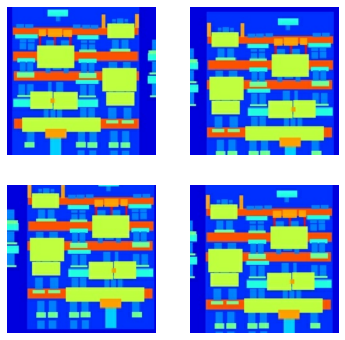

In [11]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure(figsize=(6,6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2,2,i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [12]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [13]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [14]:
def load_image_test_GAN(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, _ = normalize(input_image, real_image)

  return input_image

In [15]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset_GAN = train_dataset.map(load_image_test_GAN)
train_dataset_GAN = train_dataset_GAN.shuffle(BUFFER_SIZE)
train_dataset_GAN = train_dataset_GAN.batch(BATCH_SIZE)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

train_dataset_maps = tf.data.Dataset.list_files(PATH_MAPS+'train/*.jpg')
train_dataset_GAN_maps = train_dataset_maps.map(load_image_test_GAN)
train_dataset_GAN_maps = train_dataset_GAN_maps.shuffle(BUFFER_SIZE)
train_dataset_GAN_maps = train_dataset_GAN_maps.batch(BATCH_SIZE)
train_dataset_maps = train_dataset_maps.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset_maps = train_dataset_maps.shuffle(BUFFER_SIZE)
train_dataset_maps = train_dataset_maps.batch(BATCH_SIZE)


In [16]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

test_dataset_maps = tf.data.Dataset.list_files(PATH_MAPS+'val/*.jpg')
test_dataset_maps = test_dataset_maps.map(load_image_test)
test_dataset_maps = test_dataset_maps.batch(BATCH_SIZE)

In [17]:
OUTPUT_CHANNELS = 3

In [22]:
def make_generator_GAN_model():
  model = tf.keras.Sequential()

  model.add(layers.Dense(1*1*4096, input_shape=(4096,)))
  model.add(layers.Reshape((1,1,4096)))

  #1x1x4096
  model.add(layers.Conv2DTranspose(512,(4,4)))
  model.add(layers.ReLU())

  #4x4x256
  model.add(layers.Conv2D(256,(3,3) ,padding='same'))
  model.add(layers.BatchNormalization(momentum=0.7))
  model.add(layers.ReLU())
  model.add(layers.UpSampling2D())

  #8x8x256
  model.add(layers.Conv2D(128,(3,3), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.7))
  model.add(layers.ReLU())
  model.add(layers.UpSampling2D())

  #16x16x128
  model.add(layers.Conv2D(64,(3,3), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.7))
  model.add(layers.ReLU())
  model.add(layers.UpSampling2D())

  #32x32x64
  model.add(layers.Conv2D(32,(3,3), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.7))
  model.add(layers.ReLU())
  model.add(layers.UpSampling2D())

  #64x64x32
  model.add(layers.Conv2D(16,(3,3), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.7))
  model.add(layers.ReLU())
  model.add(layers.UpSampling2D())

  #128x128x16
  model.add(layers.Conv2D(8,(3,3), padding='same'))
  model.add(layers.ReLU())
  model.add(layers.UpSampling2D())

  #256x256x8
  model.add(layers.Conv2D(3,(3,3),activation='tanh', padding='same'))
  return model

In [23]:
generator_GAN = make_generator_GAN_model()
generator_GAN.summary()
tf.keras.utils.plot_model(generator_GAN, show_shapes=True, dpi=64)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              16781312  
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 4096)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         33554944  
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 256)         1179904   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 256)         1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 4, 4, 256)         0

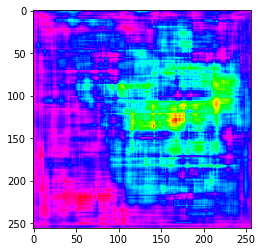

In [24]:
model = make_generator_GAN_model()
noise = tf.random.normal([1,4096])
generated_image = generator_GAN(noise, training=False)

plt.imshow(generated_image[0,:,:,0],cmap='hsv')

In [25]:
def make_discriminator_GAN_model():
  model = tf.keras.Sequential()

  #256x256x3 Image
  model.add(layers.Conv2D(8,(3,3),padding='same',input_shape=[256,256,3]))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.25))
  model.add(layers.AveragePooling2D())

  #128x128x8
  model.add(layers.Conv2D(16,(3,3), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.7))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.25))
  model.add(layers.AveragePooling2D())

  #64x64x16
  model.add(layers.Conv2D(32,(3,3), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.7))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.25))
  model.add(layers.AveragePooling2D())

  #32x32xx32
  model.add(layers.Conv2D(64,(3,3), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.7))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.25))
  model.add(layers.AveragePooling2D())

  #16x16x64
  model.add(layers.Conv2D(128,(3,3), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.7))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.25))
  model.add(layers.AveragePooling2D())

  #8x8x128
  model.add(layers.Conv2D(256,(3,3), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.7))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.25))
  model.add(layers.AveragePooling2D())

  #4x4x256
  model.add(layers.Flatten())
  model.add(layers.Dense(128))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dense(1, activation='sigmoid'))

  return model


In [26]:
discriminator_GAN = make_discriminator_GAN_model()
discriminator_GAN.summary()
tf.keras.utils.plot_model(discriminator_GAN, show_shapes=True, dpi=64)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 8)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 16)     

In [27]:
discriminator_GAN = make_discriminator_GAN_model()
decision = discriminator_GAN(generated_image)
print(decision)

tf.Tensor([[0.49971175]], shape=(1, 1), dtype=float32)


In [28]:
cross_entropy_GAN = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [29]:
def discriminator_GAN_loss(real_output, fake_output):
  real_loss = cross_entropy_GAN(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy_GAN(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [30]:
def generator_GAN_loss(fake_output):
  return cross_entropy_GAN(tf.ones_like(fake_output), fake_output)

In [31]:
generator_GAN_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_GAN_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

In [19]:
EPOCHS = 200
noise_dim_GAN = 4096
buildings_to_generate = 4

seed = tf.random.normal([buildings_to_generate, noise_dim_GAN])


In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,epoch):
  noise = tf.random.normal([BATCH_SIZE, noise_dim_GAN])

  with tf.GradientTape() as gen_tape_GAN, tf.GradientTape() as disc_tape_GAN:
    generated_images_GAN = generator_GAN(noise, training=True)

    real_output = discriminator_GAN(images, training=True)
    fake_output = discriminator_GAN(generated_images_GAN, training = True)

    gen_GAN_loss = generator_GAN_loss(fake_output)
    disc_GAN_loss = discriminator_GAN_loss(real_output, fake_output)

  gradients_of_generator_GAN = gen_tape_GAN.gradient(gen_GAN_loss, generator_GAN.trainable_variables)
  gradients_of_discriminator_GAN = disc_tape_GAN.gradient(disc_GAN_loss,discriminator_GAN.trainable_variables)

  generator_GAN_optimizer.apply_gradients(zip(gradients_of_generator_GAN, generator_GAN.trainable_variables))
  discriminator_GAN_optimizer.apply_gradients(zip(gradients_of_discriminator_GAN, discriminator_GAN.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_gan_loss', gen_GAN_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_GAN_loss, step=epoch)


In [21]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch,epoch)

    #Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator_GAN, epoch+1, seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  #GEnerate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator_GAN, epochs, seed)
  

In [43]:
def generate_and_save_images(model, epoch, test_input):
  #Notice training is set to false
  #THis is so all layers run in inference mode(batchnorm)
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(16,16))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*0.5+0.5,cmap='hsv')
    plt.axis('off')
  plt.savefig('image_generated'+str(epoch)+'.png')
  plt.show()
  return predictions


In [36]:
import datetime
log_dir_GAN="logs_GAN/"

summary_writer = tf.summary.create_file_writer(
  log_dir_GAN + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [37]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir_GAN}

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 12036.

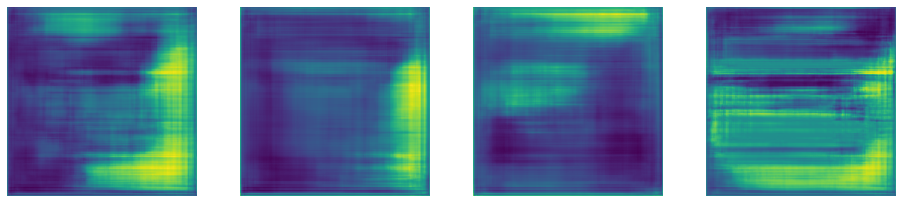

Time for epoch 91 is 4.032923460006714 sec


In [0]:
train(train_dataset_GAN, EPOCHS)

In [0]:
anim_file = 'dcgan1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*i
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [23]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [24]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [40]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [41]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [25]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

NameError: name 'generator' is not defined

In [43]:
LAMBDA = 100

In [44]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [45]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [46]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [47]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [48]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [49]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [50]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [29]:
def generate_images(model, test_input):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image',  'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

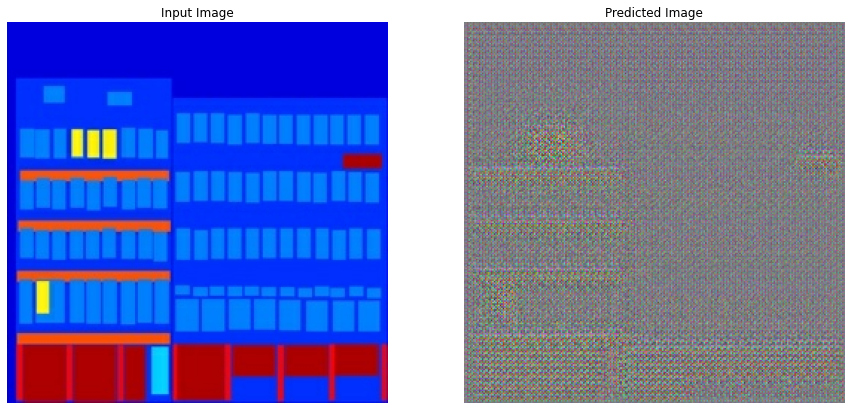

In [52]:
for example_input, _ in test_dataset.take(1):
  generate_images(generator, example_input)

In [53]:
EPOCHS_PIX2PIX = 200

In [54]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [55]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [56]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, _ in test_ds.take(1):
      generate_images(generator, example_input)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [57]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 18408.

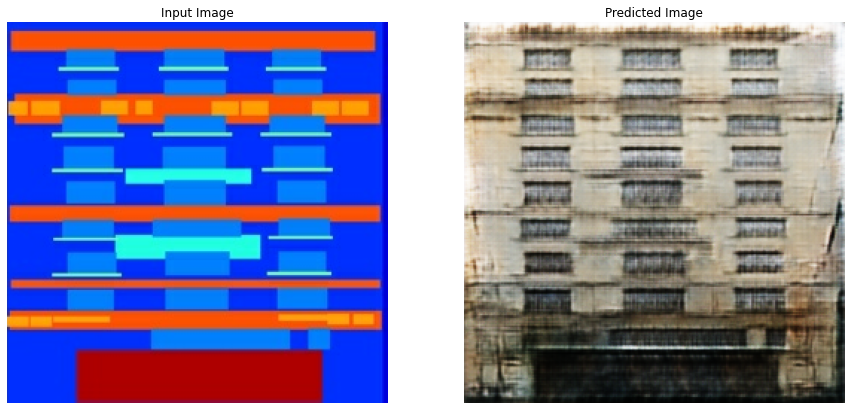

Epoch:  149
.........................
Time taken for epoch 150 is 10.874424457550049 sec



In [0]:
fit(train_dataset_maps, EPOCHS_PIX2PIX, test_dataset_maps)

In [27]:
generator = tf.keras.models.load_model('../models/generatorArchiNet',compile=False)
generator_GAN = tf.keras.models.load_model('../models/generatorDCGAN',compile=False)
generator_maps = tf.keras.models.load_model('../models/generatorArchiNetMaps',compile=False)
generator_GAN_maps = tf.keras.models.load_model('../models/generatorDCGANMaps',compile=False)

## Clădirea după translația imagine-imagine (Pix2Pix)

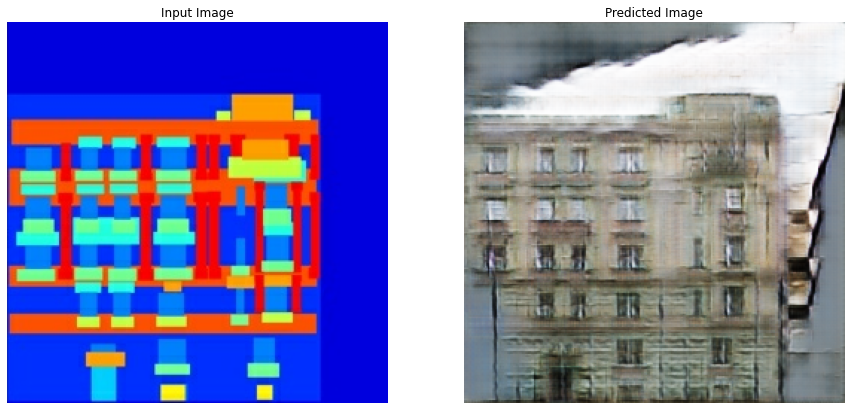

In [80]:
#Building Pix2Pix mapping
for example_input, _ in test_dataset.take(1):
  generate_images(generator, example_input)

## Hartă după translația imagine-imagine (Pix2Pix)

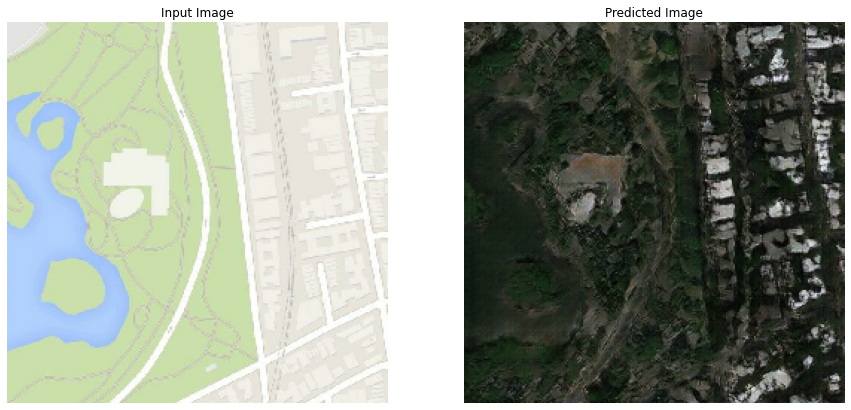

In [81]:
#Map Pix2Pix mapping
for example_input, _ in test_dataset_maps.take(1):
  generate_images(generator_maps, example_input)

## Exemple de imagini input 

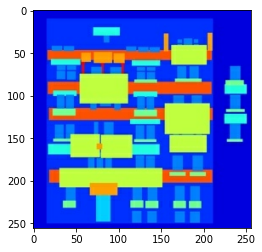

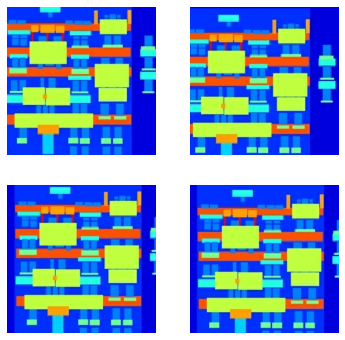

In [72]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure(figsize=(6,6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2,2,i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

## Generarea unei imagini de input a unei clădiri pentru ArchiNet in format hsv

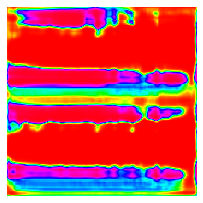

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[-0.65220284, -0.1733512 ,  0.5040307 ],
         [-0.69417995, -0.360631  ,  0.745786  ],
         [-0.6373179 , -0.41681477,  0.80800647],
         ...,
         [-0.7665418 , -0.91314954,  0.8666926 ],
         [-0.7071805 , -0.82231134,  0.8753729 ],
         [-0.33352852, -0.43052092,  0.8358712 ]],

        [[-0.86681616, -0.3524425 ,  0.6040391 ],
         [-0.8487853 , -0.12251009,  0.7945204 ],
         [-0.7717682 ,  0.03822717,  0.7909865 ],
         ...,
         [-0.93371147, -0.9548145 ,  0.86189175],
         [-0.8921691 , -0.7389703 ,  0.7880226 ],
         [-0.6996106 , -0.65900123,  0.811206  ]],

        [[-0.8886999 , -0.06297535,  0.6594536 ],
         [-0.847377  ,  0.12654659,  0.86931944],
         [-0.78402656,  0.34666264,  0.88097125],
         ...,
         [-0.9496787 , -0.96205604,  0.8465463 ],
         [-0.8993174 , -0.7852516 ,  0.7902897 ],
         [-0.69827706, -0.62184083,  0.853441 

In [82]:
#Generating building blueprint
noise = tf.random.normal([1,4096])
generate_and_save_images(generator_GAN,0,noise)

## Generarea unei imagini de input de tip hartă pentru ArchiNet in format hsv

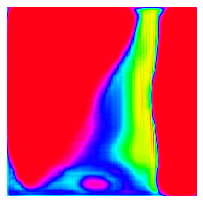

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[0.42019817, 0.4231529 , 0.4413656 ],
         [0.5425922 , 0.613012  , 0.7558522 ],
         [0.59794855, 0.6925017 , 0.8363005 ],
         ...,
         [0.74699116, 0.8253062 , 0.9701888 ],
         [0.74498683, 0.77988887, 0.9467906 ],
         [0.52275044, 0.6454434 , 0.78176105]],

        [[0.43639272, 0.5709531 , 0.5217831 ],
         [0.6680592 , 0.80654496, 0.8117613 ],
         [0.74474156, 0.86550146, 0.89012665],
         ...,
         [0.9377596 , 0.9594736 , 0.989085  ],
         [0.9369628 , 0.9406796 , 0.9764858 ],
         [0.78932637, 0.8371906 , 0.8005488 ]],

        [[0.41190004, 0.57459426, 0.5545803 ],
         [0.6414184 , 0.8055238 , 0.84618014],
         [0.722515  , 0.8678759 , 0.91556084],
         ...,
         [0.9542114 , 0.96770614, 0.99803376],
         [0.95846677, 0.9504094 , 0.99481475],
         [0.82323647, 0.8753924 , 0.91292423]],

        ...,

        [[0.36326528, 0.45268336, 

In [74]:
#Generating maps blueprint
noise = tf.random.normal([1,4096])
generate_and_save_images(generator_GAN_maps,0,noise)

## Generarea finală a unei clădiri din vector de zgomot 

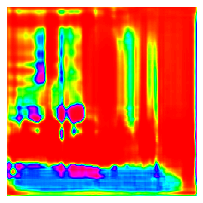

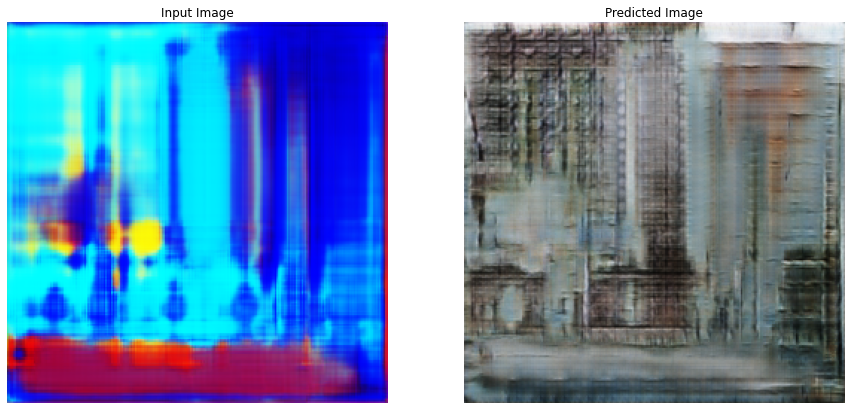

In [83]:
#Generate building from noise
image = generate_and_save_images(generator_GAN,0,tf.random.normal([1,4096]))
generate_images(generator, image)

## Generarea finală a unei hărți dintr-un vector de zgomot

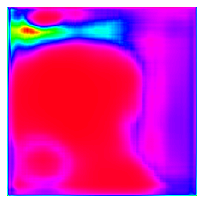

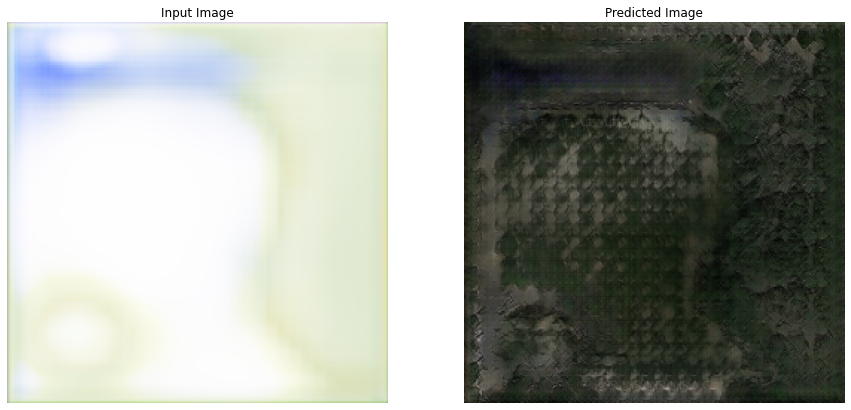

In [84]:
#Generate maps from noise
image = generate_and_save_images(generator_GAN_maps,0,tf.random.normal([1,4096]))
generate_images(generator_maps, image)